# Data labeling for evaluating TSDR accuracy with CNN model

In [1]:
%reload_ext autoreload
%autoreload 2

In [62]:
from collections import defaultdict, OrderedDict
import pathlib

import numpy as np
import pandas as pd
import torch
import torchinfo
import scipy.stats
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Sans"
plt.rcParams["font.size"] = 7
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.linewidth'] = 1.0
plt.rcParams['axes.grid'] = True

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore', FutureWarning)

In [63]:
class_to_category = OrderedDict([
    (0, 'Fluctuations/anomaly_during_fault'),
    (1, 'Fluctuations/anomaly_outside_fault'),
    (2, 'Level shift down/anomaly_during_fault'),
    (3, 'Level shift down/anomaly_outside_fault'),
    (4, 'Level shift up/anomaly_during_fault'),
    (5, 'Level shift up/anomaly_outside_fault'),
    (6, 'Multiple dips/anomaly_during_fault'),
    (7, 'Multiple dips/anomaly_outside_fault'),
    (8, 'Multiple spikes/anomaly_during_fault'),
    (9, 'Multiple spikes/anomaly_outside_fault'),
    (10, 'Other normal/no_anomaly'),
    (11, 'Single dip/anomaly_during_fault'),
    (12, 'Single dip/anomaly_outside_fault'),
    (13, 'Single spike/anomaly_during_fault'),
    (14, 'Single spike/anomaly_outside_fault'),
    (15, 'Steady decrease/anomaly_during_fault'),
    (16, 'Steady decrease/anomaly_outside_fault'),
    (17, 'Steady increase/anomaly_during_fault'),
    (18, 'Steady increase/anomaly_outside_fault'),
    (19, 'Sudden decrease/anomaly_during_fault'),
    (20, 'Sudden decrease/anomaly_outside_fault'),
    (21, 'Sudden increase/anomaly_during_fault'),
    (22, 'Sudden increase/anomaly_outside_fault'),
    (23, 'Transient level shift down/anomaly_during_fault'),
    (24, 'Transient level shift down/anomaly_outside_fault'),
    (25, 'Transient level shift up/anomaly_during_fault'),
    (26, 'Transient level shift up/anomaly_outside_fault'),
    (27, 'White noise/no_anomaly'),
])

NORMAL_CLASSES: set[int] = set([10, 27])
ANONALY_CLASSES: set[int] = set([i for i in class_to_category.keys() if i not in NORMAL_CLASSES])

TYPE0_CLASSES: set[int] = NORMAL_CLASSES
TYPE1_CLASSES: set[int] = set([2, 3, 4, 5, 15, 16, 17, 18, 19, 20, 21, 22])
TYPE2_CLASSES: set[int] = set([i for i in class_to_category.keys() if i not in TYPE0_CLASSES.union(TYPE1_CLASSES)])

In [64]:
import sys
sys.path.append("../")
from diagnoser.cnn_model import CNN1d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

model = CNN1d(num_classes=len(class_to_category))
model.load_state_dict(torch.load("models/current_best_cnn1d.pth"))
model.eval()
torchinfo.summary(model, input_size=(1, 1, 180))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1d                                    [1, 28]                   --
├─Conv1d: 1-1                            [1, 64, 177]              320
├─Conv1d: 1-2                            [1, 128, 84]              32,896
├─Conv1d: 1-3                            [1, 256, 38]              131,328
├─Dropout: 1-4                           [1, 4608]                 --
├─Linear: 1-5                            [1, 64]                   294,976
├─BatchNorm1d: 1-6                       [1, 64]                   128
├─Dropout: 1-7                           [1, 64]                   --
├─Linear: 1-8                            [1, 28]                   1,820
Total params: 461,468
Trainable params: 461,468
Non-trainable params: 0
Total mult-adds (M): 8.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 1.85
Estimated Total Size (MB): 2.10

In [95]:
from notebooklib.save import load_tsdr

DATASET_ID = "qknmc"
datasets = load_tsdr(DATASET_ID)
assert len(datasets) != 0

In [100]:
from meltria.loader import DatasetRecord

def get_well_injected_fault_dataset(_datasets) -> list[tuple[DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]]:
    well_injected_fault_dataset_entries_texts: list[str] = """
carts/pod-cpu-hog/0
carts-db/pod-memory-hog/0
payment/pod-cpu-hog/0
user/pod-cpu-hog/0
catalogue-db/pod-memory-hog/0
catalogue/pod-cpu-hog/0
orders/pod-network-loss/0
orders/pod-cpu-hog/0
catalogue-db/pod-cpu-hog/0
user-db/pod-memory-hog/0
orders/pod-memory-hog/0
carts-db/pod-cpu-hog/0
orders-db/pod-cpu-hog/0
orders-db/pod-network-loss/0
orders-db/pod-memory-hog/0
user/pod-network-loss/0
payment/pod-network-loss/0
catalogue/pod-network-loss/0
catalogue-db/pod-network-loss/0
payment/pod-memory-hog/0
front-end/pod-memory-hog/0
user/pod-memory-hog/0
user-db/pod-cpu-hog/0
catalogue/pod-memory-hog/0
carts/pod-network-loss/0
front-end/pod-cpu-hog/0
carts-db/pod-network-loss/0
carts/pod-memory-hog/0
user-db/pod-network-loss/0
    """.splitlines()
    well_injected_fault_dataset_entries: list[tuple[str, str]] = [
        tuple(line.rstrip("/0").split("/")) for line in well_injected_fault_dataset_entries_texts
    ][1:]

    well_injected_fault_datasets = [
        (record, filtered_df, anomalous_df, reduced_df) 
        for record, filtered_df, anomalous_df, reduced_df in _datasets 
        if (record.chaos_comp(), record.chaos_type()) in well_injected_fault_dataset_entries
    ]
    return well_injected_fault_datasets

In [101]:
well_injected_fault_datasets = get_well_injected_fault_dataset(datasets)
assert len(well_injected_fault_datasets) != 0

In [89]:
from torch.utils.data import Dataset
from sklearn.preprocessing import minmax_scale
from scipy.stats import zscore

import sys
sys.path.append("../")
from meltria import loader

NUM_METRICS_PER_BATCH = 100

class TSDataset(Dataset):
    def __init__(self, metrics_df: pd.DataFrame, class_to_category: dict[int, str]):
        super(TSDataset, self).__init__()
        self.metrics_df = metrics_df
        self.time_series = torch.tensor([
            self.metrics_df.loc[:, "time_series"].apply(lambda x: minmax_scale(x, feature_range=(0, 1))),
        ], dtype=torch.float32)  # use float64 to avoid error
        self.class_to_category = class_to_category

    def __getitem__(self, idx):
        return self.time_series[:, idx]

    def __len__(self):
        return len(self.metrics_df)

    def number_of_class(self) -> int:
        return len(self.class_to_category.keys())
    
    def categories(self) -> set[str]:
        return set(self.class_to_category.values())

def transform_to_testset(datasets: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]]) -> pd.DataFrame:
    items: list[dict] = []
    for record, filtered_df, _, _ in datasets:
        for col, ts in filtered_df.items():
            item = {
                "dataset_id": DATASET_ID,
                "target_app": record.target_app(),
                "chaos_comp": record.chaos_comp(),
                "chaos_type": record.chaos_type(),
                "metric": col,
                "time_series": ts.to_numpy(dtype=np.float64),
            }
            items.append(item)
    return pd.DataFrame(items)

def predict_anomaly_categories(
    records: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]],
    nn_model: CNN1d,
) -> pd.DataFrame:
    nn_model.eval()
    metrics_df: pd.DataFrame = transform_to_testset(records)
    dataset = TSDataset(metrics_df, class_to_category=class_to_category)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, pin_memory=True, shuffle=False)
    results: list[tuple[str, str, str, str, str, float]] = []
    with torch.no_grad():
        for data in dataloader:
            data = data.to(device)
            output, proba = nn_model(data)
            pred = output.argmax(dim=1, keepdim=True)
            pred_proba = proba.max(dim=1, keepdim=True).values
            for _pred, _pred_proba in zip(pred, pred_proba):
                pred_class = _pred.item()
                pred_anomaly_type: str
                match pred_class:
                    case pred_class if pred_class in TYPE0_CLASSES:
                        pred_anomaly_type = "type0"
                    case pred_class if pred_class in TYPE1_CLASSES:
                        pred_anomaly_type = "type1"
                    case pred_class if pred_class in TYPE2_CLASSES:
                        pred_anomaly_type = "type2"
                    case _:
                        assert False, f"Unknown class: {pred_class}"
                pred_binary_category = "normal" if pred_class in NORMAL_CLASSES else "anomaly"
                pred_category = dataset.class_to_category[pred_class]
                pred_anomaly_pattern, pred_anomaly_position = pred_category.split("/")
                results.append((pred_category, pred_binary_category, pred_anomaly_type, pred_anomaly_pattern, pred_anomaly_position, _pred_proba.item()))
    return metrics_df.join(pd.DataFrame(results, columns=["anomaly_raw_category", "anomaly_binary_category", "anomaly_type", "anomaly_pattern", "anomaly_position", "probability"]))

In [102]:
predicted_df: pd.DataFrame = predict_anomaly_categories(
    well_injected_fault_datasets, model,
)

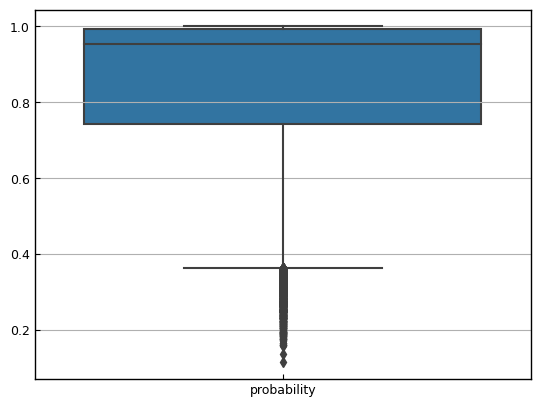

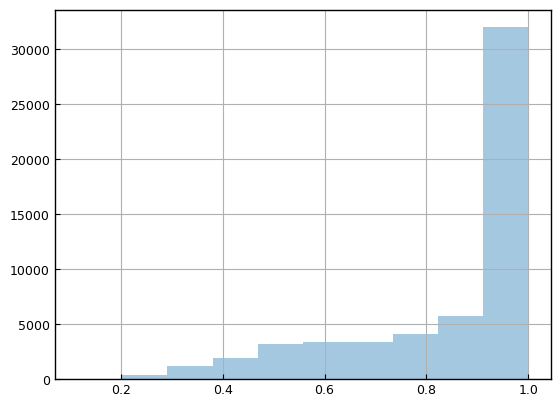

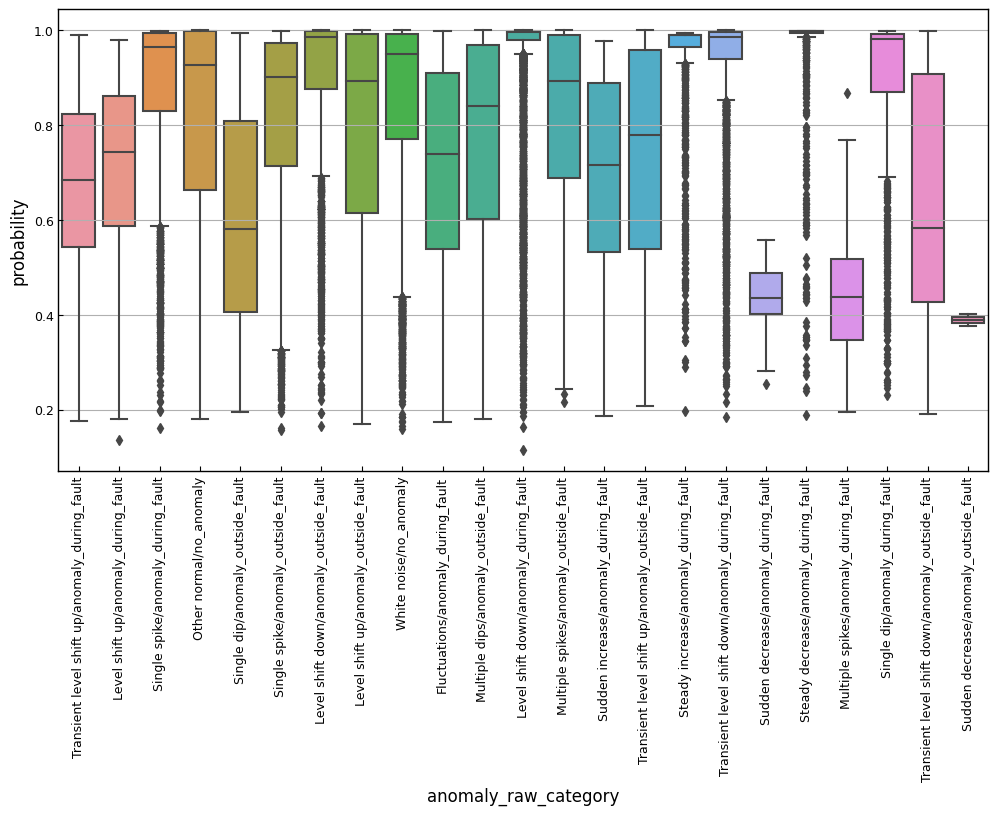

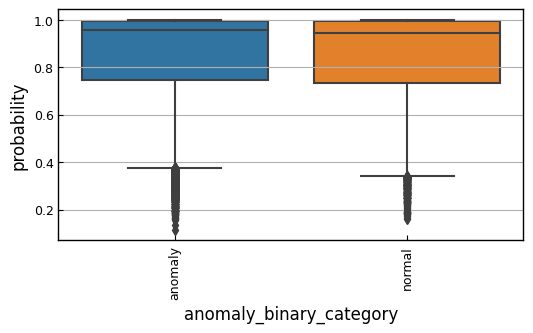

In [11]:
import seaborn as sns

sns.boxplot(data=predicted_df.loc[:, ["probability"]])
plt.show()

sns.distplot(predicted_df.loc[:, "probability"].values, kde=False, bins=10)
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))
_ax = sns.boxplot(data=predicted_df, x="anomaly_raw_category", y="probability", ax=ax)
_ax.set_xticklabels(_ax.get_xticklabels(), rotation=90)
_ax.set_xlabel(_ax.get_xlabel(), fontsize=12)
_ax.set_ylabel(_ax.get_ylabel(), fontsize=12)
plt.show()

fig2, ax2 = plt.subplots(figsize=(6, 3))
_ax2 = sns.boxplot(data=predicted_df, x="anomaly_binary_category", y="probability", ax=ax2)
_ax2.set_xticklabels(_ax2.get_xticklabels(), rotation=90)
_ax2.set_xlabel(_ax2.get_xlabel(), fontsize=12)
_ax2.set_ylabel(_ax2.get_ylabel(), fontsize=12)
plt.show()

In [15]:
import math
from dataclasses import dataclass

import ipywidgets as widgets
from IPython.display import HTML

NUM_ITEMS_BY_PAGE: int = 20
NUM_FAULT_DATAPOINTS: int = (60 // 15) * 5  # 15 sec sampling to 5min


@dataclass(frozen=True)
class TSWindowForAL:
    num_total_categories: int
    num_current_categories: int
    anomaly_pattern_name: str
    anomaly_position_name: str
    num_total_metrics_in_current_category: int
    num_current_metrics_in_current_category: int
    metrics_df_in_current_page: pd.DataFrame
    anomaly_min_distance: pd.Series
    
    def title_as_html(self) -> HTML:
        return HTML(f"<h3>Category: {self.anomaly_pattern_name}/{self.anomaly_position_name} - {self.num_current_categories}/{self.num_total_categories}</h3>")

    def msg_for_current_page(self) -> str:
        return f"Showing {self.num_current_metrics_in_current_category} of {self.num_total_metrics_in_current_category} metrics in the current pattern"
    
    def plots(self, axs) -> None:
        for ax in axs.flatten():
            ax.clear()
        for i, (ax, item) in enumerate(zip(axs.flatten(), self.metrics_df_in_current_page.itertuples())):
            ax.plot(item.time_series)
            ax.set_title(
                f"{item.Index}:\n {item.chaos_type}/{item.chaos_comp}/{item.metric}",
                wrap=True,
            )
            ax.axvspan(
                item.time_series.size - NUM_FAULT_DATAPOINTS,
                item.time_series.size, 
                color='red', alpha=0.5,
            )

def create_widget_for_active_learning(yield_on_click, num_items_by_page: int = NUM_ITEMS_BY_PAGE) -> widgets.Box:
    all_correct_button = widgets.Button(description='All correct')
    skip_category_button = widgets.Button(description='Skip Category')
    mislabeled_items_selector = widgets.SelectMultiple(
        options=[],
        rows=num_items_by_page+2,
        disabled=False,
        layout=widgets.Layout(width='40%'),
        description='Selected mislabeled items',
    )
    title_output = widgets.Output(layout={'border': '1px solid black'})
    msg_output = widgets.Output(layout={'border': '1px solid black'})
    fig_output = widgets.Output(layout={'border': '1px solid black'})
    log_output = widgets.Output(layout={'border': '1px solid black'})

    plt.rcParams["font.size"] = 11
    plt.rcParams['xtick.labelsize'] = 8
    plt.rcParams['ytick.labelsize'] = 8
    fig, axs = plt.subplots(
        nrows=num_items_by_page//5,
        ncols=5,
        figsize=(35, 3.5 * math.ceil(num_items_by_page / 5)),
        clear=True,
    )

    def show(tsw: TSWindowForAL) -> None:
        with title_output:
            title_output.clear_output(wait=True)
            display(tsw.title_as_html())
        with msg_output:
            msg_output.clear_output(wait=True)
            display(tsw.msg_for_current_page())

        tsw.plots(axs)
        with fig_output:
            fig_output.clear_output(wait=True)
            display(fig)
        
        with log_output:
            log_output.clear_output(wait=True)
            display(tsw.anomaly_min_distance)
        
        mislabeled_items_selector.options = tsw.metrics_df_in_current_page.index.tolist()

    def on_all_correct_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindowForAL = yield_on_click.send((mislabeled_items_selector.value))
        show(tsw)

    all_correct_button.on_click(on_all_correct_click_callback)
    plt.close(fig=fig)
    show(next(yield_on_click))

    def on_skip_category_click_callback(clicked_button: widgets.Button) -> None:
        tsw: TSWindowForAL = yield_on_click.send(("skip_category"))
        with msg_output:
            msg_output.clear_output(wait=True)
            display(f"Category skipped")
        show(tsw)
    
    skip_category_button.on_click(on_skip_category_click_callback)

    return widgets.VBox([
        title_output,
        msg_output,
        fig_output,
        widgets.HBox([all_correct_button, skip_category_button]),
        widgets.HBox([mislabeled_items_selector, log_output]),
    ])


import datetime
from collections import defaultdict
import pathlib

import jsonlines

SAVE_DIR = pathlib.Path("../samples/tsdr_anomaly_patterns")

def generator_for_manual_batch_confirmation(
    predicted_df: pd.DataFrame,
    mode: str = "mislabeled",  # or "labeled"
    sort_by: str = "probability",
    group_by: str = "anomaly_raw_category",
    ascending: bool = False,
    time: str = datetime.datetime.today().strftime('%Y%m%d-%H%M%S'),
):
    save_file_path: pathlib.Path = SAVE_DIR / f"{mode}_tsdr_anomaly_patterns_{time}.jsonl"

    grped_predicted_df = predicted_df.sort_values(sort_by, ascending=ascending).groupby(group_by)
    for i, (acategory, grped_df) in enumerate(grped_predicted_df):
        for j in range(0, grped_df.shape[0], NUM_ITEMS_BY_PAGE):
            # make pager
            predicted_df_by_page: pd.DataFrame = grped_df.iloc[j:j+NUM_ITEMS_BY_PAGE]
            apattern, aposition = str(acategory).split("/") if "/" in str(acategory) else (str(acategory), "")
            tsw = TSWindowForAL(
                num_total_categories=len(grped_predicted_df),
                num_current_categories=i+1,
                num_total_metrics_in_current_category=grped_df.shape[0],
                num_current_metrics_in_current_category=j+1,
                anomaly_pattern_name=apattern,
                anomaly_position_name=aposition,
                metrics_df_in_current_page=predicted_df_by_page,
                anomaly_min_distance=predicted_df_by_page[sort_by],
            )

            # Sent tsw to the UI widget's callback
            (v) = (yield tsw)
            if v == "skip_category":  # if skip_category button is clicked
                break
            mislabeled_df_index = v

            with jsonlines.open(str(save_file_path), mode='a', flush=True) as writer:
                for mislabeled_idx in mislabeled_df_index:
                    mislabeled_df = predicted_df_by_page.loc[mislabeled_idx, :]
                    item = {
                        "dataset_id": DATASET_ID, 
                        "target_app": mislabeled_df["target_app"], 
                        "chaos_type": mislabeled_df["chaos_type"],
                        "chaos_comp": mislabeled_df["chaos_comp"],
                        "metric": mislabeled_df["metric"],
                        "time_series": mislabeled_df["time_series"].tolist(),
                    }
                    match mode:
                        case "mislabeled":
                            item.update({
                                "mislabeled_anomaly_pattern": apattern,
                                "mislabeled_anomaly_position": aposition,
                            })
                        case "labeled":
                            item.update({
                                "anomaly_pattern": apattern,
                                "anomaly_position": aposition,
                            })
                        case _:
                            assert False, f"Unknown mode: {mode}"
                    writer.write(item)

In [16]:
bins = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
# proba_groups = pd.cut(predicted_df.groupby("category")["probability"], bins=bins)
random_sampled_predicted_df = predicted_df.groupby(["anomaly_raw_category", pd.cut(predicted_df.probability, bins=bins)]).sample(n=1, replace=True, random_state=1)
create_widget_for_active_learning(
    generator_for_manual_batch_confirmation(random_sampled_predicted_df)
)

In [17]:
bins = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0]
random_sampled_predicted_binary_df = predicted_df.groupby(["anomaly_binary_category", pd.cut(predicted_df.probability, bins=bins)]).sample(n=5, replace=True, random_state=1)
create_widget_for_active_learning(
    generator_for_manual_batch_confirmation(random_sampled_predicted_binary_df)
)

## Relabeling with CNN without anomaly position label

In [65]:
class_to_category_without_ap = OrderedDict([
    (0, 'Fluctuations'),
    (1, 'Level shift down'),
    (2, 'Level shift up'),
    (3, 'Multiple dips'),
    (4, 'Multiple spikes'),
    (5, 'Other normal'),
    (6, 'Single dip'),
    (7, 'Single spike'),
    (8, 'Steady decrease'),
    (9, 'Steady increase'),
    (10, 'Sudden decrease'),
    (11, 'Sudden increase'),
    (12, 'Transient level shift down'),
    (13, 'Transient level shift up'),
    (14, 'White noise'),
])

NORMAL_CLASSES: set[int] = set([5, 14])
ANONALY_CLASSES: set[int] = set([i for i in class_to_category_without_ap.keys() if i not in NORMAL_CLASSES])

In [66]:
from diagnoser.cnn_model import CNN1d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

model_without_ap = CNN1d(num_classes=len(class_to_category_without_ap))
model_without_ap.load_state_dict(torch.load("models/current_best_cnn1d_without_ap_with_da.pth"))
model_without_ap.eval()
torchinfo.summary(model_without_ap, input_size=(1, 1, 180))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1d                                    [1, 15]                   --
├─Conv1d: 1-1                            [1, 64, 177]              320
├─Conv1d: 1-2                            [1, 128, 84]              32,896
├─Conv1d: 1-3                            [1, 256, 38]              131,328
├─Dropout: 1-4                           [1, 4608]                 --
├─Linear: 1-5                            [1, 64]                   294,976
├─BatchNorm1d: 1-6                       [1, 64]                   128
├─Dropout: 1-7                           [1, 64]                   --
├─Linear: 1-8                            [1, 15]                   975
Total params: 460,623
Trainable params: 460,623
Non-trainable params: 0
Total mult-adds (M): 8.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 1.84
Estimated Total Size (MB): 2.10

In [21]:
predicted_df_without_ap: pd.DataFrame = predict_anomaly_categories(
    well_injected_fault_datasets, model_without_ap,
)

In [22]:
create_widget_for_active_learning(
    generator_for_manual_batch_confirmation(predicted_df_without_ap, ascending=True),
)

In [25]:
def transform_to_samples_df(datasets: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]], dataset_idx: int = 1) -> pd.DataFrame:
    items: list[dict] = []
    for dataset in datasets:
        record, dfs = dataset[0], dataset[1:]
        data_df: pd.DataFrame = dfs[dataset_idx]
        for col, ts in data_df.items():
            item = {
                "dataset_id": DATASET_ID,
                "target_app": record.target_app(),
                "chaos_comp": record.chaos_comp(),
                "chaos_type": record.chaos_type(),
                "metric": col,
                "time_series": ts.to_numpy(dtype=np.float64),
            }
            items.append(item)
    return pd.DataFrame(items)

def eval_tsdr_on_predicted_label_as_ground_truth(
    datasets: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]],
    predicted_binary_df: pd.DataFrame,
) -> pd.DataFrame:
    index_columns = ["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric"]
    scores: list[tuple[str, str, str, str, int, int, int, int, int, int, float, float, float, float]] = []
    for dataset in datasets:
        reduced_samples_df = transform_to_samples_df([dataset]).set_index(index_columns).drop(columns=["time_series"])
        record: loader.DatasetRecord = dataset[0]
        _predicted_binary_df = predicted_binary_df.query(f"dataset_id == '{DATASET_ID}' and target_app == '{record.target_app()}' and chaos_type == '{record.chaos_type()}' and chaos_comp == '{record.chaos_comp()}'").set_index(index_columns).drop(columns=["time_series"])
        anomaly_df = _predicted_binary_df[_predicted_binary_df["anomaly_binary_category"] == "anomaly"]
        normal_df = _predicted_binary_df[_predicted_binary_df["anomaly_binary_category"] == "normal"]
        total = _predicted_binary_df.shape[0]
        tp, fp = anomaly_df[anomaly_df.index.isin(reduced_samples_df.index)].shape[0], normal_df[normal_df.index.isin(reduced_samples_df.index)].shape[0]
        fn, tn = anomaly_df.shape[0] - tp, normal_df.shape[0] - fp
        assert total == tp + fp + fn + tn
        acc = (tp + tn) / (tp + tn + fp + fn)
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2 * precision * recall / (precision + recall)
        scores.append((
            DATASET_ID, record.target_app(), record.chaos_type(), record.chaos_comp(),
            anomaly_df.shape[0], normal_df.shape[0], tp, fp, fn, tn, acc, precision, recall, f1,
        ))
    return pd.DataFrame(scores, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "anomaly", "normal", "tp", "fp", "fn", "tn", "acc", "precision", "recall", "f1"])

In [26]:
_datasets = well_injected_fault_datasets
scores_df = eval_tsdr_on_predicted_label_as_ground_truth(
    _datasets, predict_anomaly_categories(_datasets, model_without_ap),
)
with pd.option_context("display.precision", 2):
    display(scores_df)
    display(scores_df.agg(["mean", "max", "min", "std"]).drop(columns=["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

,dataset_id,target_app,chaos_type,chaos_comp,anomaly,normal,tp,fp,fn,tn,acc,precision,recall,f1
0,qknmc,sock-shop,pod-cpu-hog,carts,1351,621,1294,299,57,322,0.82,0.81,0.96,0.88
1,qknmc,sock-shop,pod-memory-hog,carts-db,1533,486,1489,211,44,275,0.87,0.88,0.97,0.92
2,qknmc,sock-shop,pod-cpu-hog,payment,1200,762,1155,425,45,337,0.76,0.73,0.96,0.83
3,qknmc,sock-shop,pod-cpu-hog,user,1192,691,1121,345,71,346,0.78,0.76,0.94,0.84
4,qknmc,sock-shop,pod-memory-hog,catalogue-db,1374,571,1329,276,45,295,0.83,0.83,0.97,0.89
5,qknmc,sock-shop,pod-cpu-hog,catalogue,1084,805,1024,429,60,376,0.74,0.70,0.94,0.81
6,qknmc,sock-shop,pod-network-loss,orders,1401,522,1370,217,31,305,0.87,0.86,0.98,0.92
7,qknmc,sock-shop,pod-cpu-hog,orders,1307,606,1258,306,49,300,0.81,0.80,0.96,0.88
8,qknmc,sock-shop,pod-cpu-hog,catalogue-db,1161,763,1098,376,63,387,0.77,0.74,0.95,0.83
9,qknmc,sock-shop,pod-memory-hog,user-db,1587,468,1550,209,37,259,0.88,0.88,0.98,0.93


,anomaly,normal,tp,fp,fn,tn,acc,precision,recall,f1
mean,1384.14,563.52,1341.93,268.76,42.21,294.76,0.84,0.83,0.97,0.89
max,1610.00,805.00,1576.00,429.00,71.00,387.00,0.90,0.90,0.98,0.94
min,1084.00,409.00,1024.00,168.00,27.00,223.00,0.74,0.70,0.94,0.81
std,132.68,109.47,141.67,72.18,11.45,42.17,0.04,0.05,0.01,0.04


## Evaluation Phase 2

In [103]:
# load model
from diagnoser.cnn_model import CNN1d

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 1
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)

model_with_da = CNN1d(num_classes=len(class_to_category))
model_with_da.load_state_dict(torch.load("models/current_best_cnn1d_with_da.pth"))
model_with_da.eval()
torchinfo.summary(model_with_da, input_size=(1, 1, 180))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1d                                    [1, 28]                   --
├─Conv1d: 1-1                            [1, 64, 177]              320
├─Conv1d: 1-2                            [1, 128, 84]              32,896
├─Conv1d: 1-3                            [1, 256, 38]              131,328
├─Dropout: 1-4                           [1, 4608]                 --
├─Linear: 1-5                            [1, 64]                   294,976
├─BatchNorm1d: 1-6                       [1, 64]                   128
├─Dropout: 1-7                           [1, 64]                   --
├─Linear: 1-8                            [1, 28]                   1,820
Total params: 461,468
Trainable params: 461,468
Non-trainable params: 0
Total mult-adds (M): 8.11
Input size (MB): 0.00
Forward/backward pass size (MB): 0.26
Params size (MB): 1.85
Estimated Total Size (MB): 2.10

In [104]:
from meltria.priorknowledge.priorknowledge import SockShopKnowledge

pk = SockShopKnowledge(
    target_metric_types={
        "containers": True,
        "services": True,
        "middlewalres": True,
        "nodes": False,
    },
    mappings={"nodes-containers": {}})

def eval_tsdr_type_on_predicted_label_as_ground_truth(
    datasets: list[tuple[loader.DatasetRecord, pd.DataFrame, pd.DataFrame, pd.DataFrame]],
    predicted_df: pd.DataFrame,
) -> pd.DataFrame:
    index_columns = ["dataset_id", "target_app", "chaos_type", "chaos_comp", "metric"]
    scores: list[tuple[str, str, str, str, float, float]] = []
    for dataset in datasets:
        reduced_samples_df = transform_to_samples_df([dataset], dataset_idx=2).set_index(index_columns).drop(columns=["time_series"])
        anomalous_samples_df = transform_to_samples_df([dataset], dataset_idx=1).set_index(index_columns).drop(columns=["time_series"])
        record: loader.DatasetRecord = dataset[0]
        _predicted_df = predicted_df.query(f"dataset_id == '{DATASET_ID}' and target_app == '{record.target_app()}' and chaos_type == '{record.chaos_type()}' and chaos_comp == '{record.chaos_comp()}'")
        # group by service
        _predicted_df["service"] = _predicted_df["metric"].apply(lambda x: pk.get_service_by_metric(x))
        _predicted_df["container"] = _predicted_df["metric"].apply(lambda x: pk.get_container_by_metric(x))
        _predicted_df["node"] = _predicted_df["metric"].apply(lambda x: pk.get_node_by_metric(x))

        # overlap reduced_samples_df and _predicted_df 
        _predicted_df = _predicted_df.set_index(index_columns).drop(columns=["time_series"])
        merged_reduced_df = reduced_samples_df.merge(_predicted_df, how="inner", left_index=True, right_index=True)
        merged_anomalous_df = anomalous_samples_df.merge(_predicted_df, how="inner", left_index=True, right_index=True)
        count_patterns_by_phase_df = merged_anomalous_df.groupby(["container", "anomaly_pattern", "anomaly_position"]).size().rename("phase1").to_frame().merge(merged_reduced_df.groupby(["container", "anomaly_pattern", "anomaly_position"]).size().rename("phase2"), how="left", left_index=True, right_index=True).fillna(0)
        count_types_by_phase_df = merged_anomalous_df.groupby(["container", "anomaly_type", "anomaly_position"]).size().rename("phase1").to_frame().merge(merged_reduced_df.groupby(["container", "anomaly_type", "anomaly_position"]).size().rename("phase2"), how="left", left_index=True, right_index=True).fillna(0)
        during_faults_patterns = count_patterns_by_phase_df.query("anomaly_position == 'anomaly_during_fault'")
        during_faults_types = count_types_by_phase_df.query("anomaly_position == 'anomaly_during_fault'")
        scores.append((
            DATASET_ID, record.target_app(), record.chaos_type(), record.chaos_comp(), 
            1 - during_faults_patterns.query("phase2 == 0").count()[0] / during_faults_patterns.count()[0],
            1 - during_faults_types.query("phase2 == 0").count()[0] / during_faults_types.count()[0],
        ))
    return pd.DataFrame(scores, columns=["dataset_id", "target_app", "chaos_type", "chaos_comp", "during_fault_recall(pattern)", "during_fault_recall(type)"])

### Evaluation with HDBSCAN + SBD

In [105]:
_datasets = well_injected_fault_datasets
scores_hdbscan_sbd_df = eval_tsdr_type_on_predicted_label_as_ground_truth(
    _datasets, predict_anomaly_categories(_datasets, model_with_da),
)
with pd.option_context("display.precision", 2):
    display(scores_hdbscan_sbd_df)
    display(scores_hdbscan_sbd_df.agg(["mean", "max", "min", "std"]).drop(columns=["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

,dataset_id,target_app,chaos_type,chaos_comp,during_fault_recall(pattern),during_fault_recall(type)
0,qknmc,sock-shop,pod-cpu-hog,carts,0.53,0.86
1,qknmc,sock-shop,pod-memory-hog,carts-db,0.53,0.90
2,qknmc,sock-shop,pod-cpu-hog,payment,0.48,0.76
3,qknmc,sock-shop,pod-cpu-hog,user,0.53,0.76
4,qknmc,sock-shop,pod-memory-hog,catalogue-db,0.60,0.86
5,qknmc,sock-shop,pod-cpu-hog,catalogue,0.62,0.89
6,qknmc,sock-shop,pod-network-loss,orders,0.55,0.90
7,qknmc,sock-shop,pod-cpu-hog,orders,0.54,0.82
8,qknmc,sock-shop,pod-cpu-hog,catalogue-db,0.51,0.81
9,qknmc,sock-shop,pod-memory-hog,user-db,0.60,0.91


,during_fault_recall(pattern),during_fault_recall(type)
mean,0.56,0.86
max,0.65,0.95
min,0.44,0.76
std,0.05,0.06


### Evaluation with fluxrank

In [106]:
well_injected_fault_datasets_fluxrank = get_well_injected_fault_dataset(load_tsdr(DATASET_ID, suffix="fluxrank"))

In [110]:
_datasets = well_injected_fault_datasets_fluxrank
scores_fluxrank_df = eval_tsdr_type_on_predicted_label_as_ground_truth(
    _datasets, predict_anomaly_categories(_datasets, model_with_da),
)
with pd.option_context("display.precision", 2):
    display(scores_fluxrank_df)
    display(scores_fluxrank_df.agg(["mean", "max", "min", "std"]).drop(columns=["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

,dataset_id,target_app,chaos_type,chaos_comp,during_fault_recall(pattern),during_fault_recall(type)
0,qknmc,sock-shop,pod-cpu-hog,carts,0.77,1.00
1,qknmc,sock-shop,pod-memory-hog,carts-db,0.73,1.00
2,qknmc,sock-shop,pod-cpu-hog,payment,0.81,1.00
3,qknmc,sock-shop,pod-cpu-hog,user,0.89,1.00
4,qknmc,sock-shop,pod-memory-hog,catalogue-db,0.78,0.95
5,qknmc,sock-shop,pod-cpu-hog,catalogue,0.77,0.94
6,qknmc,sock-shop,pod-network-loss,orders,0.67,1.00
7,qknmc,sock-shop,pod-cpu-hog,orders,0.83,0.95
8,qknmc,sock-shop,pod-cpu-hog,catalogue-db,0.76,0.95
9,qknmc,sock-shop,pod-memory-hog,user-db,0.74,0.91


,during_fault_recall(pattern),during_fault_recall(type)
mean,0.74,0.98
max,0.90,1.00
min,0.63,0.91
std,0.06,0.03


### Hierarchical Clustering + SBD

In [111]:
well_injected_fault_datasets_hier_sbd = get_well_injected_fault_dataset(load_tsdr(DATASET_ID, suffix="hier_sbd"))

In [112]:
_datasets = well_injected_fault_datasets_hier_sbd
scores_sbd_hier_df = eval_tsdr_type_on_predicted_label_as_ground_truth(
    _datasets, predict_anomaly_categories(_datasets, model_with_da),
)
with pd.option_context("display.precision", 2):
    display(scores_sbd_hier_df)
    display(scores_sbd_hier_df.agg(["mean", "max", "min", "std"]).drop(columns=["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

,dataset_id,target_app,chaos_type,chaos_comp,during_fault_recall(pattern),during_fault_recall(type)
0,qknmc,sock-shop,pod-cpu-hog,carts,1.00,1.00
1,qknmc,sock-shop,pod-memory-hog,carts-db,0.96,1.00
2,qknmc,sock-shop,pod-cpu-hog,payment,1.00,1.00
3,qknmc,sock-shop,pod-cpu-hog,user,1.00,1.00
4,qknmc,sock-shop,pod-memory-hog,catalogue-db,1.00,1.00
5,qknmc,sock-shop,pod-cpu-hog,catalogue,1.00,1.00
6,qknmc,sock-shop,pod-network-loss,orders,1.00,1.00
7,qknmc,sock-shop,pod-cpu-hog,orders,0.97,1.00
8,qknmc,sock-shop,pod-cpu-hog,catalogue-db,1.00,1.00
9,qknmc,sock-shop,pod-memory-hog,user-db,1.00,1.00


,during_fault_recall(pattern),during_fault_recall(type)
mean,0.99,9.98e-01
max,1.00,1.00e+00
min,0.94,9.52e-01
std,0.02,8.84e-03


### HDBSCAN + Pearsonr

In [114]:
well_injected_fault_datasets_hdbscan_pearsonr = get_well_injected_fault_dataset(load_tsdr(DATASET_ID, suffix="hdbscan_pearsonr"))

In [116]:
_datasets = well_injected_fault_datasets_hdbscan_pearsonr
scores_hdbscan_pearsonr = eval_tsdr_type_on_predicted_label_as_ground_truth(
    _datasets, predict_anomaly_categories(_datasets, model_with_da),
)
with pd.option_context("display.precision", 2):
    display(scores_hdbscan_pearsonr)
    display(scores_hdbscan_pearsonr.agg(["mean", "max", "min", "std"]).drop(columns=["dataset_id", "target_app", "chaos_type", "chaos_comp"]))

,dataset_id,target_app,chaos_type,chaos_comp,during_fault_recall(pattern),during_fault_recall(type)
0,qknmc,sock-shop,pod-cpu-hog,carts,0.52,0.86
1,qknmc,sock-shop,pod-memory-hog,carts-db,0.54,0.86
2,qknmc,sock-shop,pod-cpu-hog,payment,0.53,0.76
3,qknmc,sock-shop,pod-cpu-hog,user,0.51,0.76
4,qknmc,sock-shop,pod-memory-hog,catalogue-db,0.64,1.00
5,qknmc,sock-shop,pod-cpu-hog,catalogue,0.58,0.83
6,qknmc,sock-shop,pod-network-loss,orders,0.52,0.75
7,qknmc,sock-shop,pod-cpu-hog,orders,0.51,0.77
8,qknmc,sock-shop,pod-cpu-hog,catalogue-db,0.47,0.81
9,qknmc,sock-shop,pod-memory-hog,user-db,0.59,0.91


,during_fault_recall(pattern),during_fault_recall(type)
mean,0.54,0.85
max,0.64,1.00
min,0.44,0.70
std,0.04,0.08


### Comparinson with all clustering methods

In [113]:
with pd.option_context("display.precision", 2):
    index_columns = ["dataset_id", "target_app", "chaos_type", "chaos_comp"]
    concated_scores_df = pd.concat([scores_sbd_hier_df.set_index(index_columns), scores_hdbscan_sbd_df.set_index(index_columns), scores_fluxrank_df.set_index(index_columns), scores_hdbscan_pearsonr.set_index(index_columns)], keys=["hier/sbd", "hdbscan/sbd", "fluxrank", "hdbscan/pearsonr"], axis=1)
    display(concated_scores_df)
    display(concated_scores_df.agg(["mean", "max", "min", "std"]))

hier/sbd  \
                                                    during_fault_recall(pattern)   
dataset_id target_app chaos_type       chaos_comp                                  
qknmc      sock-shop  pod-cpu-hog      carts                                1.00   
                      pod-memory-hog   carts-db                             0.96   
                      pod-cpu-hog      payment                              1.00   
                                       user                                 1.00   
                      pod-memory-hog   catalogue-db                         1.00   
                      pod-cpu-hog      catalogue                            1.00   
                      pod-network-loss orders                               1.00   
                      pod-cpu-hog      orders                               0.97   
                                       catalogue-db                         1.00   
                      pod-memory-hog   user-db                              1.00   
                                       orders                               0.97   
                      pod-cpu-hog      carts-db                             1.00   
                                       orders-db                            1.00   
                      pod-network-loss orders-db                            0.98   
                      pod-memory-hog   orders-db                            0.94   
                      pod-network-loss user                                 0.98   
                                       payment                              0.94   
                                       catalogue                            0.97   
                                       catalogue-db                         0.99   
                      pod-memory-hog   payment                              0.99   
                                       front-end                            0.99   
                                       user                                 1.00   
                      pod-cpu-hog      user-db                              0.98   
                      pod-memory-hog   catalogue                            1.00   
                      pod-network-loss carts                                0.98   
                      pod-cpu-hog      front-end                            1.00   
                      pod-network-loss carts-db                             0.98   
                      pod-memory-hog   carts                                1.00   
                      pod-network-loss user-db                              0.98   

                                                                               \
                                                    during_fault_recall(type)   
dataset_id target_app chaos_type       chaos_comp                               
qknmc      sock-shop  pod-cpu-hog      carts                             1.00   
                      pod-memory-hog   carts-db                          1.00   
                      pod-cpu-hog      payment                           1.00   
                                       user                              1.00   
                      pod-memory-hog   catalogue-db                      1.00   
                      pod-cpu-hog      catalogue                         1.00   
                      pod-network-loss orders                            1.00   
                      pod-cpu-hog      orders                            1.00   
                                       catalogue-db                      1.00   
                      pod-memory-hog   user-db                           1.00   
                                       orders                            1.00   
                      pod-cpu-hog      carts-db                          1.00   
                                       orders-db                         1.00   
                      pod-network-loss orders-db                         1.00   
      

hier/sbd                            \
     during_fault_recall(pattern) during_fault_recall(type)   
mean                         0.99                  9.98e-01   
max                          1.00                  1.00e+00   
min                          0.94                  9.52e-01   
std                          0.02                  8.84e-03   

                  hdbscan/peasonr                            \
     during_fault_recall(pattern) during_fault_recall(type)   
mean                         0.56                      0.86   
max                          0.65                      0.95   
min                          0.44                      0.76   
std                          0.05                      0.06   

                         fluxrank                            
     during_fault_recall(pattern) during_fault_recall(type)  
mean                         0.74                      0.98  
max                          0.90                      1.00  
min                          0.63                      0.91  
std                          0.06                      0.03